## Data and Imports

In [ ]:
import tensorflow 
import numpy as np
from torchvision.datasets import EMNIST
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv
import math
import pickle

In [ ]:


def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
from DBN import DBN


### Torch Tensors

In [ ]:
# !rm -rf 'data_pytorch'


In [ ]:
emnist_data = EMNIST(root="data_pytorch/", split="balanced", download=True, train=True, 
                transform=tt.Compose([
                    lambda img: tt.functional.rotate(img, -90),
                    lambda img: tt.functional.hflip(img),
                    tt.ToTensor()
                ]))
                
# test_dataset = EMNIST(root="data_pytorch/", split="balanced", download=True, train=False, 
#                 transform=tt.Compose([
#                     lambda img: tt.functional.rotate(img, -90),
#                     lambda img: tt.functional.hflip(img),
#                     tt.ToTensor()
#                 ]))

In [ ]:
# print("Total No of Images in EMNIST dataset:", len(dataset) + len(test_dataset))
print("No of images in Training dataset:    ",len(emnist_data))
# print("No of images in Testing dataset:     ",len(test_dataset))

No of images in Training dataset:     112800


In [ ]:
emnist_data.data = (emnist_data.data.type(torch.FloatTensor)/255)

In [ ]:
l = emnist_data.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

No of classes:  47
List of all classes
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


The number shown is the label: r


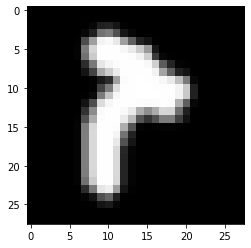

In [ ]:
idx = 0
img = emnist_data.data[idx]
print("The number shown is the label: {}".format(l[emnist_data.targets[idx]]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [ ]:
samples = int(len(emnist_data)*0.3)
emnist_data_train = emnist_data.data[samples:, :]
emnist_targets_train = emnist_data.targets[samples:]

emnist_data_test = emnist_data.data[:samples, :]
emnist_targets_test = emnist_data.targets[:samples]

In [ ]:
emnist_data_train.shape

torch.Size([78960, 28, 28])

In [ ]:
emnist_data_test.shape

torch.Size([33840, 28, 28])

### Numpy arrays

In [ ]:
!pip install emnist

In [ ]:
from emnist import extract_training_samples
train_images, train_labels = extract_training_samples('balanced')

In [ ]:
train_images.shape

(112800, 28, 28)

In [ ]:

from emnist import extract_test_samples
test_images, test_labels  = extract_test_samples('balanced')

In [ ]:
test_images.shape

(18800, 28, 28)

In [ ]:
label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
len(label)

47

In [ ]:
# Normalise
train_images = train_images.astype('float32')
train_images /= 255
test_images = test_images.astype('float32')
test_images /= 255

## Utility

In [ ]:
def show_example(dataset, idx):
    img, label = dataset[idx]
    print("The label is: {}".format(l[label]) )
    plt.imshow(img[0] , cmap = 'gray')


In [ ]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [ ]:
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights,figname=""):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot
  if figname!="":
    plt.savefig(figname)

In [ ]:
def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr
  
def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(47)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(47)])
def _plot_dendrogram(mean_repr_matrix, figname,title=""):
  fig, ax = plt.subplots(figsize=(10,5))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_xticklabels(label,rotation=0)
  ax.set_title(title)
  plt.savefig(figname)


In [ ]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

The label is: 4


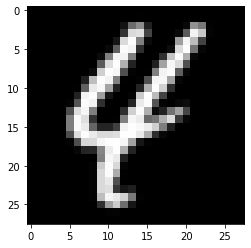

In [ ]:
show_example(emnist_data, 4)

The label is: 1


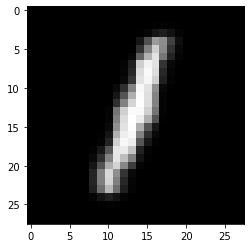

In [ ]:
show_example(emnist_data, 9)


The label is: 3


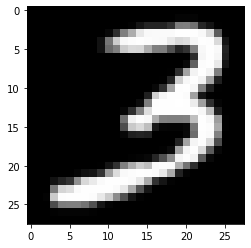

In [ ]:
show_example(emnist_data, 25)


## Models

### RBM simple

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=True) # set to true if u have gpu

In [ ]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0455   |0.0357   |328.6291 |6.2466   |
|20    |0.9824   |0.0324   |303.4350 |5.0593   |
|30    |0.9641   |0.0310   |296.1305 |4.8482   |
|40    |0.9538   |0.0316   |292.9296 |5.2064   |
|50    |0.9483   |0.0309   |290.6097 |5.0832   |


#### Visualizing receptive fields

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

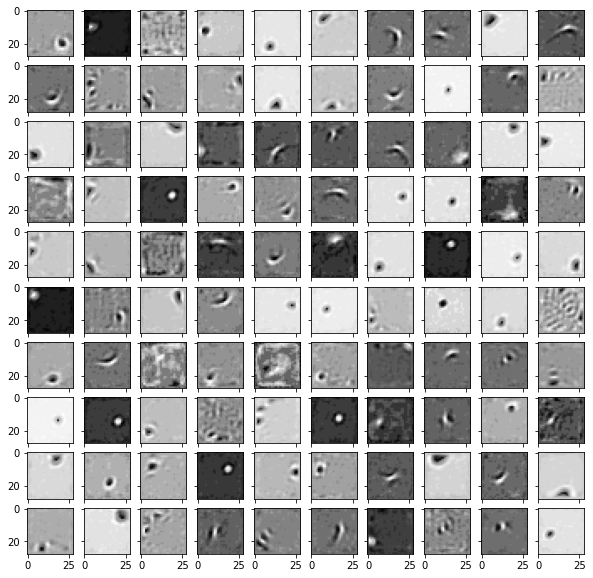

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)

_plot_layer_receptive_fields(learned_weights_layer_1, "weights DBN 1")

#### Clustering internal representations

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
# hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)

In [ ]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
# label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)

In [ ]:

mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
# mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)

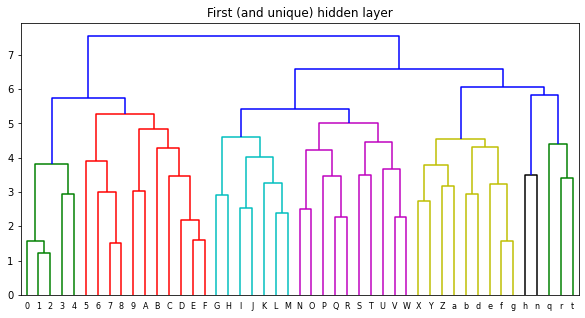

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "dendogram RBM 1 layer","First (and unique) hidden layer")

#### Linear read-out

In [ ]:

class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 47)

  def forward(self, x):
    return self.linear(x)

In [ ]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.Adam(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_targets_train)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
# hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
# hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
# hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1 , epochs=1000)
# rbm_layer_size

epoch 0/1000, loss = 3.888561
epoch 100/1000, loss = 0.463411
epoch 200/1000, loss = 0.392784
epoch 300/1000, loss = 0.359724
epoch 400/1000, loss = 0.340333
epoch 500/1000, loss = 0.327775
epoch 600/1000, loss = 0.316853
epoch 700/1000, loss = 0.308150
epoch 800/1000, loss = 0.303046
epoch 900/1000, loss = 0.297284


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
# hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
# hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
# hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)


In [ ]:
predictions = perceptron_first_hidden(hidden_repr_layer_1_test)


In [ ]:
predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
predictions_indices

tensor([45, 44, 43,  ..., 41, 38, 42])

In [ ]:
_compute_accuracy(predictions, emnist_targets_test)

0.8276300430297852

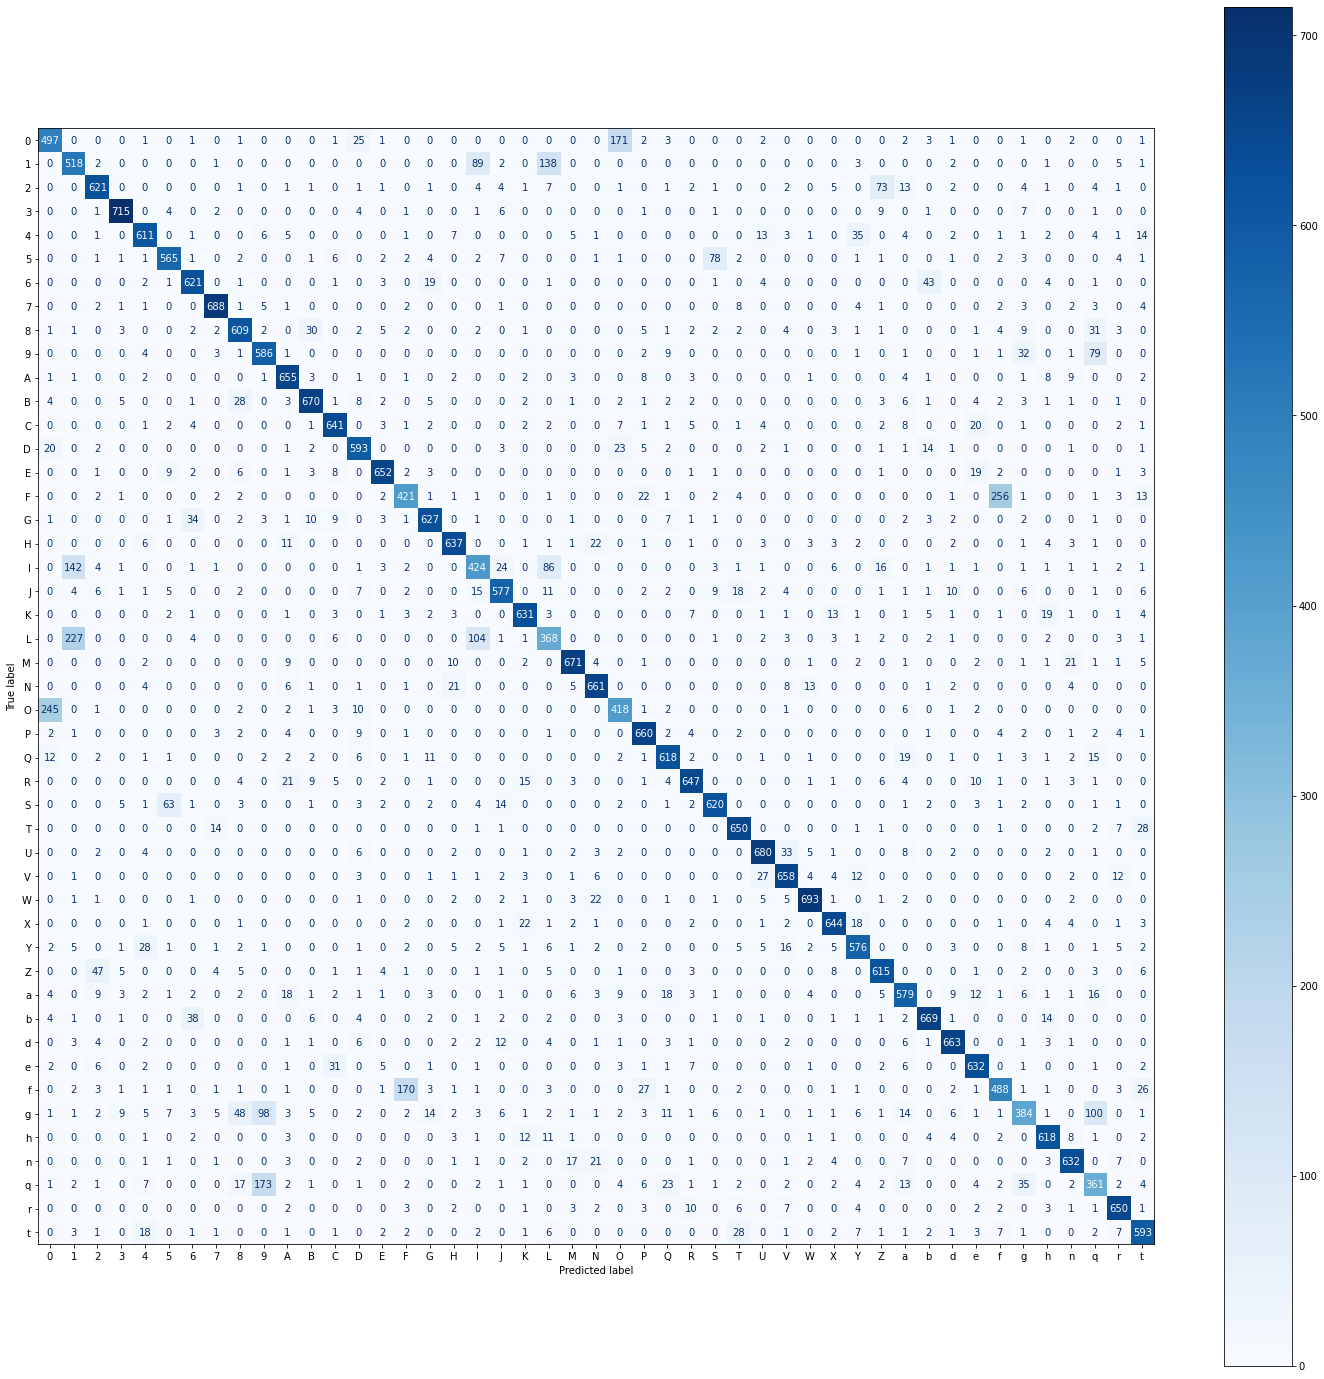

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(emnist_targets_test, predictions_indices)
fig, ax = plt.subplots(figsize=(25, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig("cm for RBM 1")
plt.show()

#### Noise


In [ ]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

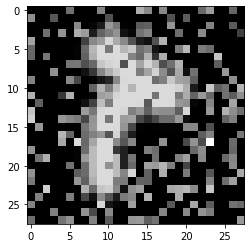

In [ ]:
noise_level = 0.3
mnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28), cmap="gray")

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, 47)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output
ffnn = Feedforward(500)

In [ ]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.Adam(network.parameters())
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_targets_train)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [ ]:
_train(ffnn,  emnist_data_train.reshape((78960, 784)), epochs=120)


epoch 0/120, loss = 3.449474
epoch 10/120, loss = 2.211951
epoch 20/120, loss = 1.537441
epoch 30/120, loss = 1.302872
epoch 40/120, loss = 1.191681
epoch 50/120, loss = 1.112427
epoch 60/120, loss = 1.044237
epoch 70/120, loss = 0.979606
epoch 80/120, loss = 0.917246
epoch 90/120, loss = 0.858221
epoch 100/120, loss = 0.803834
epoch 110/120, loss = 0.754693


In [ ]:
predictions_ffnn = ffnn(emnist_data_test.reshape((emnist_data_test.shape[0], 784)))


In [ ]:
_compute_accuracy(predictions_ffnn, emnist_targets_test)


0.7751182317733765

In [ ]:
emnist_data_train.shape

torch.Size([78960, 28, 28])

In [ ]:
def _get_accuracy_values_at_noise_level(noise_level):
  emnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(emnist_test_with_noise, 0)  # here we compute the representations
  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_1_noisy)  # here we use the readout layer
  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((mnist_test_with_noise.shape[0], 784)))
  accuracy_first_hidden = _compute_accuracy(predictions_first_hidden_noisy, emnist_targets_test)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy,emnist_targets_test)
  return accuracy_first_hidden, accuracy_ffnn

In [ ]:
_get_accuracy_values_at_noise_level(0.2)


(0.48377659916877747, 0.19601063430309296)

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_ffnn = _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "FFNN"])

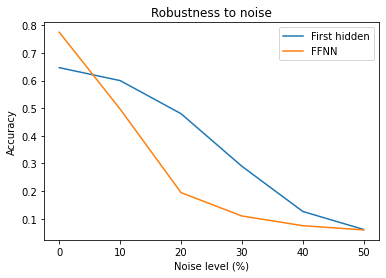

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(noise_levels)

### RBM 2

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units= [500,  500],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=True) # set to true if u have gpu

In [ ]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0465   |0.0348   |329.7227 |6.2440   |
|20    |0.9845   |0.0325   |305.5958 |5.3635   |
|30    |0.9622   |0.0308   |296.6749 |5.0474   |
|40    |0.9556   |0.0312   |294.5702 |5.4614   |
|50    |0.9489   |0.0314   |292.3108 |4.8933   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1106   |0.0335   |225.4494 |3.4706   |
|20    |1.0362   |0.0284   |216.7138 |3.0593   |
|30    |1.0218   |0.0297   |216.1195 |3.1068   |
|40    |1.0140   |0.0288   |215.3169 |3.0258   |
|50    |1.0106   |0.0293   |214.1383 |2.8740   |


In [ ]:
import pickle
pickle.dump(dbn_emnist, open( "dbn_2", "wb" ))


In [ ]:
loaded = pickle.load( open( "dbn_2", "rb" ) )

In [ ]:
loaded

DBN()

#### Visualizing receptive fields

In [ ]:
_move_parameters_to_cpu(dbn_emnist)
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1.shape

(500, 784)

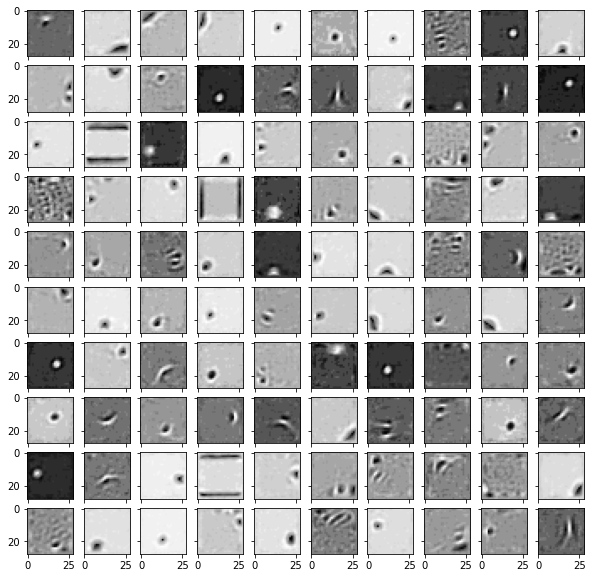

In [ ]:
_plot_layer_receptive_fields(learned_weights_layer_1, "weights layer 1 DBN 2")

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()


learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

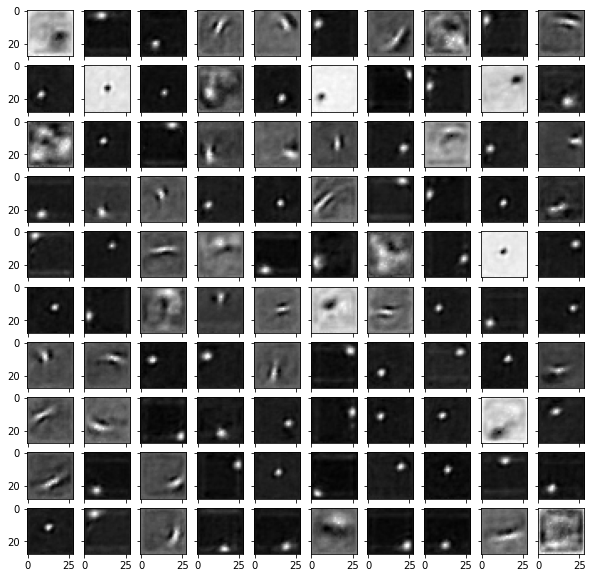

In [ ]:


_plot_layer_receptive_fields(learned_weights_product, "weights layer 2 DBN 2")

In [ ]:
learned_weights_layer_2.shape

(500, 500)

#### Clustering internal representations

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
# hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)


In [ ]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
# label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)


In [ ]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
# mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)


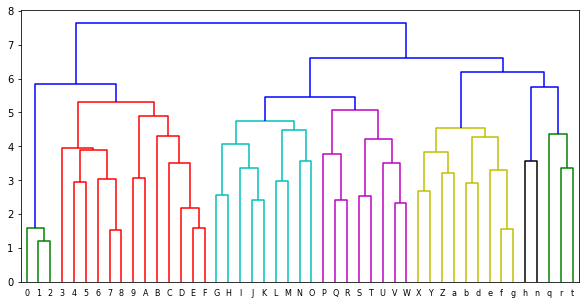

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "dendogram layer 1 DBN 2")

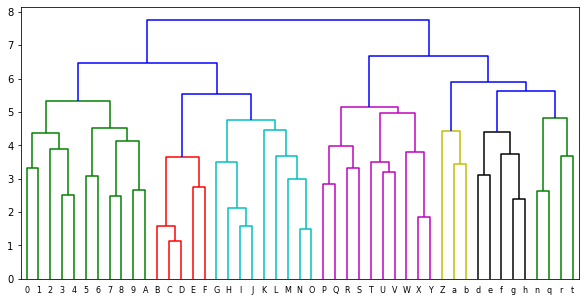

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "dendogram layer 2 DBN 2")

In [ ]:
# _plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")


#### Linear read-out

In [ ]:

class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 47)

  def forward(self, x):
    return self.linear(x)

In [ ]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.Adam(network.parameters())
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_targets_train)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0 or epoch==epochs:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
# hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
# hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]
perceptron_last_hidden = Perceptron(rbm_layer_size)
_train(perceptron_last_hidden, hidden_repr_layer_2 , epochs=1000)

epoch 0/1000, loss = 3.898944
epoch 100/1000, loss = 1.496696
epoch 200/1000, loss = 1.129002
epoch 300/1000, loss = 0.972174
epoch 400/1000, loss = 0.877701
epoch 500/1000, loss = 0.811586


KeyboardInterrupt: ignored

In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-2].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1 , epochs=1000)

epoch 0/1000, loss = 3.893646
epoch 100/1000, loss = 1.459539
epoch 200/1000, loss = 1.186833
epoch 300/1000, loss = 1.069619
epoch 400/1000, loss = 0.997240
epoch 500/1000, loss = 0.944930
epoch 600/1000, loss = 0.903813
epoch 700/1000, loss = 0.869844
epoch 800/1000, loss = 0.840877
epoch 900/1000, loss = 0.815641


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
# hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
# hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)


In [ ]:
predictions_last_layer = perceptron_last_hidden(hidden_repr_layer_2_test)
predictions_first_layer = perceptron_first_hidden(hidden_repr_layer_1_test)


In [ ]:
predictions_indices = predictions_last_layer.max(axis=1).indices  # convert probabilities to indices
predictions_indices

tensor([45, 20, 43,  ..., 41, 38, 42])

In [ ]:
print("First layer accuracy", _compute_accuracy(predictions_first_layer, emnist_targets_test))
print("Last layer accuracy", _compute_accuracy(predictions_last_layer, emnist_targets_test))


First layer accuracy 0.756708025932312
Last layer accuracy 0.7550827264785767


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(emnist_targets_test, predictions_indices)
fig, ax = plt.subplots(figsize=(25, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig("cm for RBM 2")

plt.show()

#### Noise


In [ ]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

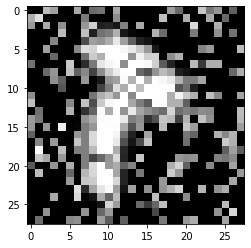

In [ ]:
noise_level = 0.3
emnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28), cmap="gray")

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, 784)
    self.third_hidden = torch.nn.Linear(784, 500)


    self.output = torch.nn.Linear(500, 47)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))


    output = self.output(third_hidden_repr)
    return output
ffnn = Feedforward(500)

In [ ]:
_train(ffnn,  emnist_data_train.reshape((78960, 784)), epochs=150)


epoch 0/150, loss = 3.850397


KeyboardInterrupt: ignored

In [ ]:
predictions_ffnn = ffnn(emnist_data_test.reshape((emnist_data_test.shape[0], 784)))


In [ ]:
_compute_accuracy(predictions_ffnn, emnist_targets_test)


In [ ]:
emnist_data_train.shape

In [ ]:
def _get_accuracy_values_at_noise_level(noise_level):
  emnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(emnist_test_with_noise, 0)  
  hidden_repr_layer_2_noisy = _get_kth_layer_repr(hidden_repr_layer_1_noisy, 1)  

  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_1_noisy)
  predictions_last_hidden_noisy = perceptron_last_hidden(hidden_repr_layer_2_noisy)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((mnist_test_with_noise.shape[0], 784)))
  accuracy_first_hidden = _compute_accuracy(predictions_first_hidden_noisy, emnist_targets_test)
  accuracy_last_hidden = _compute_accuracy(predictions_last_hidden_noisy, emnist_targets_test)
  
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy,emnist_targets_test)
  return accuracy_first_hidden,accuracy_last_hidden, accuracy_ffnn

In [ ]:
_get_accuracy_values_at_noise_level(0.2)


In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_last_hidden = []

  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden, accuracy_last_hidden,accuracy_ffnn = _get_accuracy_values_at_noise_level(noise_level)

    accuracy_values_first_hidden.append(accuracy_first_hidden)
    accuracy_values_last_hidden.append(accuracy_last_hidden)

    accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_last_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)


  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden","FFNN"])

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(noise_levels)

### RBM 3

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units= [784,784, 784],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=True) # set to true if u have gpu

In [ ]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0195   |0.0341   |379.8314 |7.1276   |
|20    |0.9527   |0.0293   |348.8995 |6.1068   |
|30    |0.9321   |0.0293   |340.7472 |5.6591   |
|40    |0.9201   |0.0293   |338.2218 |5.3596   |
|50    |0.9133   |0.0282   |338.8972 |5.0400   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.7168   |0.0223   |274.8823 |3.7963   |
|20    |0.6647   |0.0192   |265.0774 |3.3321   |
|30    |0.6542   |0.0196   |265.1079 |3.4220   |
|40    |0.6490   |0.0188   |265.8886 |3.6069   |
|50    |0.6470   |0.0181   |267.8258 |3.5858   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6730   |0.0218   |257.9698 |4.1725   |
|20    |0.6043   |0.0193   |233.0977 |3.8795   |
|30    |0.5819   |0.0179   |226.8056 |3.2504   |
|40    |0.5716   |0.0166   |224.3889 |3.4972   |
|50    |0.5664

In [ ]:
import pickle
pickle.dump(dbn_emnist, open( "dbn_3", "wb" ))


#### Visualizing receptive fields

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1.shape

(784, 784)

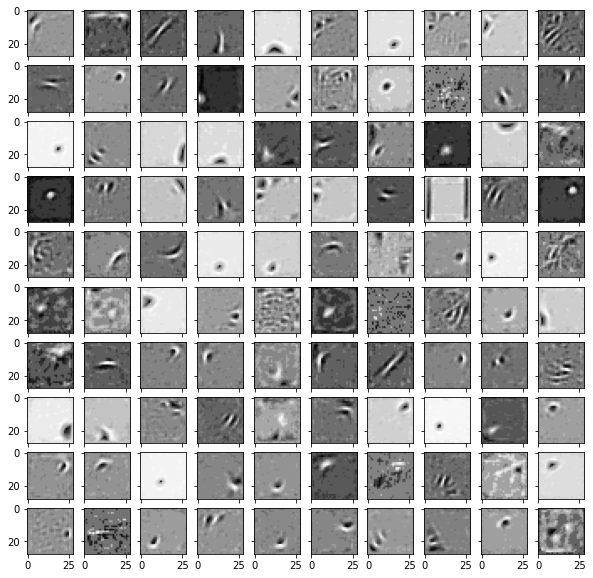

In [ ]:


_plot_layer_receptive_fields(learned_weights_layer_1)

In [ ]:
learned_weights_layer_1_for_product = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1_for_product = _apply_threshold(learned_weights_layer_1_for_product, 0)
learned_weights_layer_2_for_product = _apply_threshold(learned_weights_layer_2_for_product, 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(784, 784)

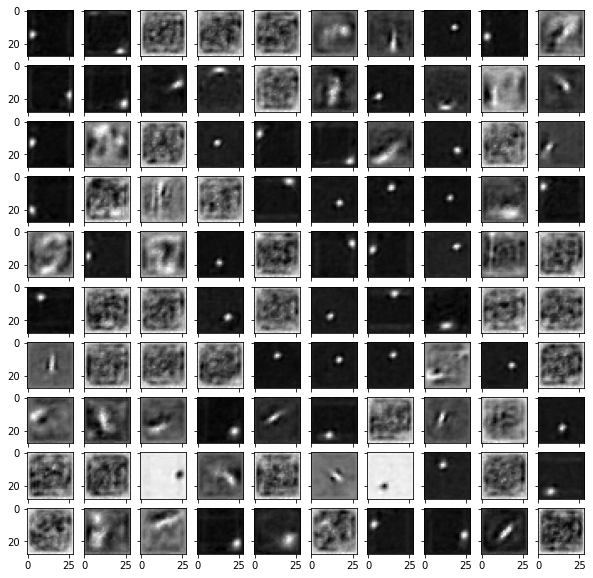

In [ ]:
_plot_layer_receptive_fields(learned_weights_product)


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(784, 784)

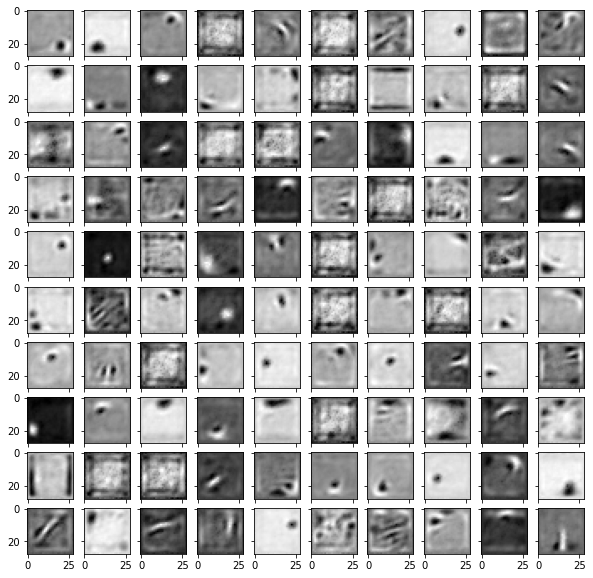

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "weights layer 3 DBN 3")


#### Clustering internal representations

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)


In [ ]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)


In [ ]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)


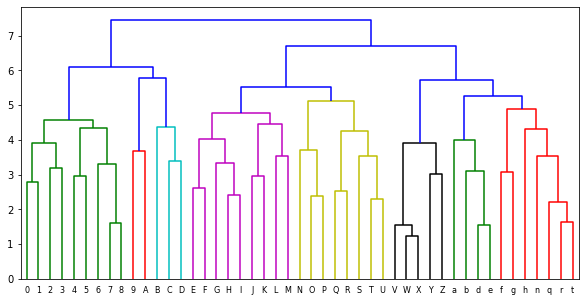

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "dendogram layer 1 DBN 3")

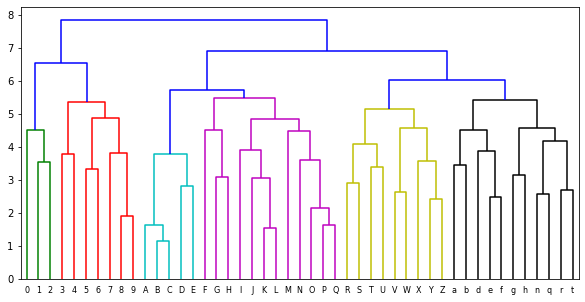

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "dendogram layer 2 DBN 3")

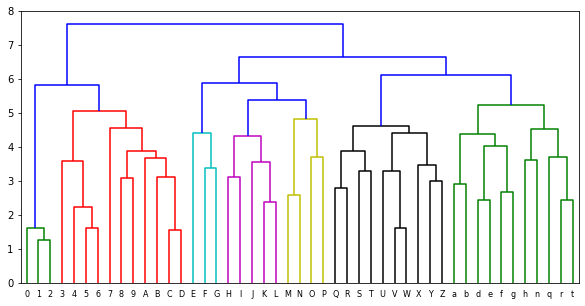

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "dendogram layer 3 DBN 3")


#### Linear read-out

In [ ]:

class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 47)

  def forward(self, x):
    return self.linear(x)

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
# hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_1 , epochs=1000)

epoch 0/1000, loss = 3.875975
epoch 100/1000, loss = 1.286693
epoch 200/1000, loss = 0.921521
epoch 300/1000, loss = 0.769047
epoch 400/1000, loss = 0.679785
epoch 500/1000, loss = 0.619321
epoch 600/1000, loss = 0.574817
epoch 700/1000, loss = 0.540225
epoch 800/1000, loss = 0.512271
epoch 900/1000, loss = 0.489008


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
perceptron_second_hidden = Perceptron(rbm_layer_size)
_train(perceptron_second_hidden, hidden_repr_layer_2 , epochs=1000)

epoch 0/1000, loss = 3.875135
epoch 100/1000, loss = 1.475608
epoch 200/1000, loss = 1.125025
epoch 300/1000, loss = 0.974079
epoch 400/1000, loss = 0.882410
epoch 500/1000, loss = 0.817705
epoch 600/1000, loss = 0.768172
epoch 700/1000, loss = 0.728333
epoch 800/1000, loss = 0.695213
epoch 900/1000, loss = 0.667020


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
perceptron_third_hidden = Perceptron(rbm_layer_size)
_train(perceptron_third_hidden, hidden_repr_layer_3 , epochs=1000)

epoch 0/1000, loss = 3.878250
epoch 100/1000, loss = 1.312780
epoch 200/1000, loss = 0.943862
epoch 300/1000, loss = 0.792750
epoch 400/1000, loss = 0.704881
epoch 500/1000, loss = 0.645460
epoch 600/1000, loss = 0.601733
epoch 700/1000, loss = 0.567748
epoch 800/1000, loss = 0.540295
epoch 900/1000, loss = 0.517467


In [ ]:
pickle.dump(perceptron_first_hidden, open( "perceptron_first_hidden_dbn_3", "wb" ))
pickle.dump(perceptron_second_hidden, open( "perceptron_second_hidden_dbn_3", "wb" ))
pickle.dump(perceptron_third_hidden, open( "perceptron_third_hidden_dbn_3", "wb" ))


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
# hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)


In [ ]:
predictions_first_layer = perceptron_first_hidden(hidden_repr_layer_1_test)
predictions_second_layer = perceptron_second_hidden(hidden_repr_layer_2_test)
predictions_third_layer = perceptron_third_hidden(hidden_repr_layer_3_test)


In [ ]:
predictions_indices = predictions_third_layer.max(axis=1).indices  # convert probabilities to indices
predictions_indices

tensor([45, 36, 43,  ..., 41, 38, 42])

In [ ]:
print("First layer accuracy", _compute_accuracy(predictions_first_layer, emnist_targets_test))
print("Second layer accuracy", _compute_accuracy(predictions_second_layer, emnist_targets_test))
print("Third layer accuracy", _compute_accuracy(predictions_third_layer, emnist_targets_test))


First layer accuracy 0.8334220051765442
Second layer accuracy 0.7929964661598206
Third layer accuracy 0.8256796598434448


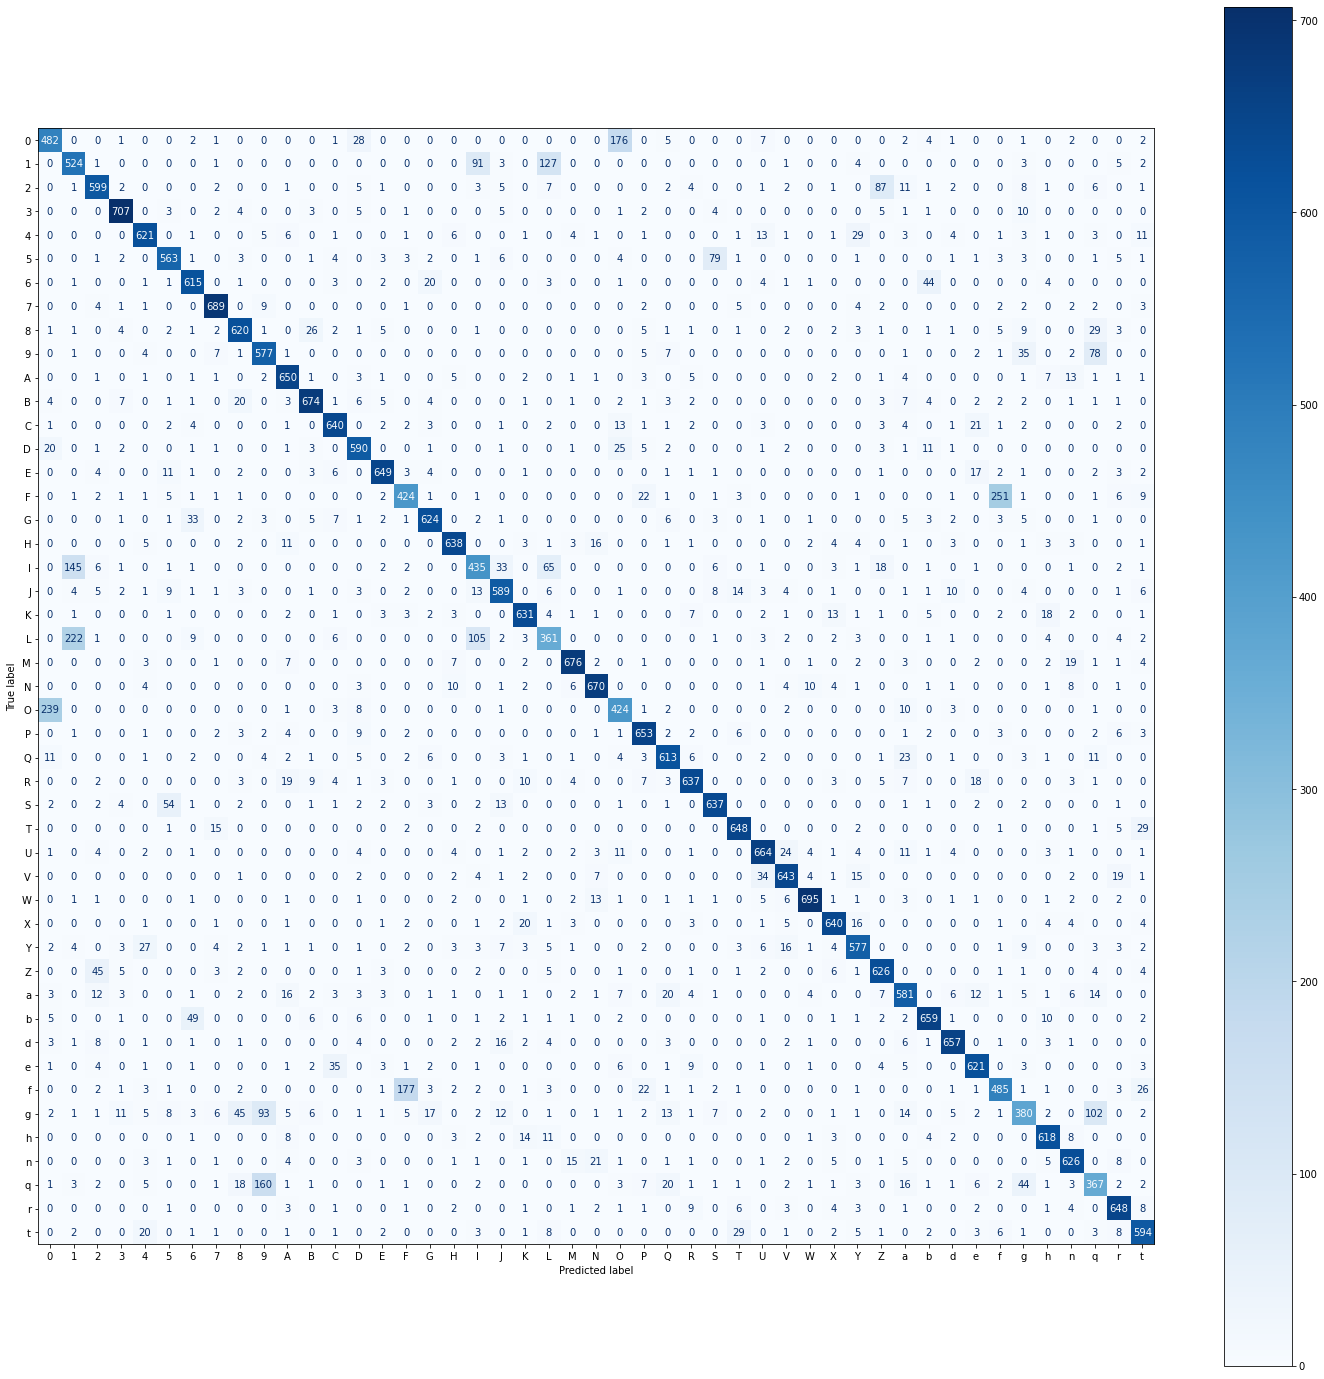

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(emnist_targets_test, predictions_indices)
fig, ax = plt.subplots(figsize=(25, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig("cm for RBM 3")

plt.show()

#### Noise??

In [ ]:
def _inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(emnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return emnist_data - mask_tensor * emnist_data + mask_tensor * random_gaussian_tensor

In [ ]:
noise_level = 0.3
mnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28), cmap="gray")

In [ ]:
def _get_accuracy_values_at_noise_level(noise_level):
  mnist_test_with_noise = _inject_noise(emnist_data_test, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(mnist_test_with_noise, 0)  # here we compute the representations
  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_1_noisy)  # here we use the readout layer
  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((10000, 784)))
  accuracy_first_hidden = _compute_accuracy(predictions_first_hidden_noisy, emnist_targets_test)
  accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy,emnist_targets_test)
  return accuracy_first_hidden, accuracy_ffnn

### RBM 4

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units= [500,  500,  500, 2000],
                k=1,
                learning_rate=0.01,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=True,
                increase_to_cd_k=False,
                use_gpu=True) # set to true if u have gpu

In [ ]:

num_epochs = 50
batch_size = 10

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.1035   |0.0111   |101.5919 |2.7839   |
|20    |0.0984   |0.0103   |94.7988 |2.6071   |
|30    |0.0966   |0.0099   |92.2501 |2.5442   |
|40    |0.0954   |0.0099   |90.7709 |2.6036   |
|50    |0.0948   |0.0098   |89.9561 |2.6207   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.1101   |0.0098   |70.4390 |1.5840   |
|20    |0.1037   |0.0093   |67.6500 |1.6005   |
|30    |0.1024   |0.0092   |66.8748 |1.6002   |
|40    |0.1021   |0.0093   |66.6083 |1.5986   |
|50    |0.1015   |0.0091   |66.2712 |1.6075   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.1005   |0.0099   |69.0312 |1.6720   |
|20    |0.0910   |0.0089   |62.4015 |1.5153   |
|30    |0.0880   |0.0088   |60.7046 |1.5327   |
|40    |0.0866   |0.0085   |59.8722 |1.5036   |
|50    |0.0861   |0.0084   

In [ ]:
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.Adam(network.parameters())
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, emnist_targets_train)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

#### Visualizing receptive fields

##### Standard parameters

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1.shape

(500, 784)

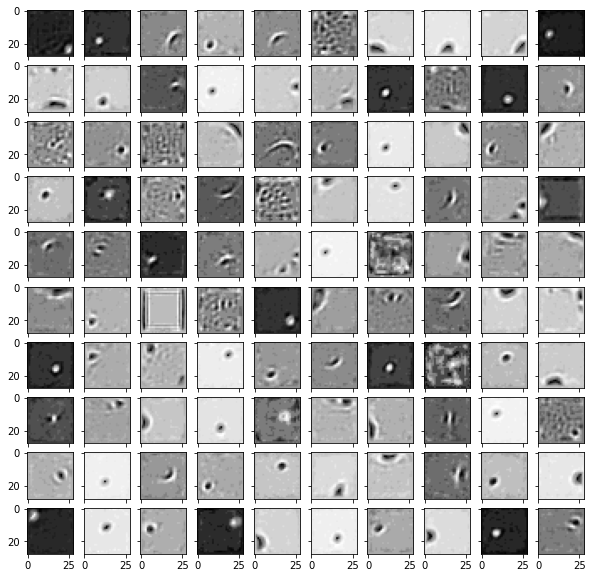

In [ ]:


_plot_layer_receptive_fields(learned_weights_layer_1)

In [ ]:
learned_weights_layer_1_for_product = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1_for_product = _apply_threshold(learned_weights_layer_1_for_product, 0)
learned_weights_layer_2_for_product = _apply_threshold(learned_weights_layer_2_for_product, 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

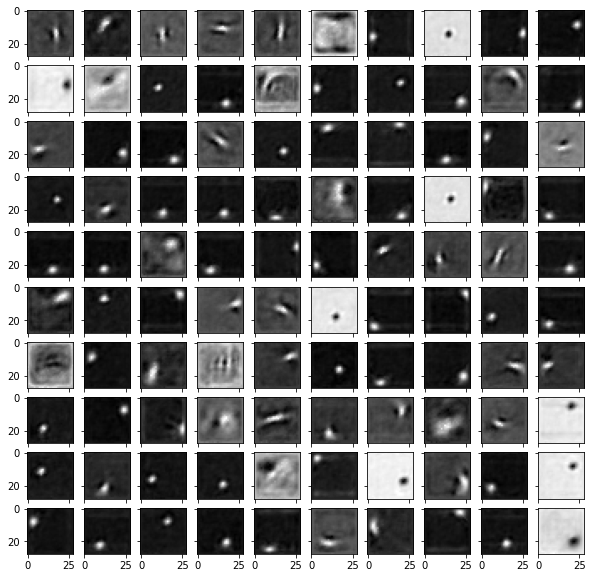

In [ ]:
_plot_layer_receptive_fields(learned_weights_product)


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

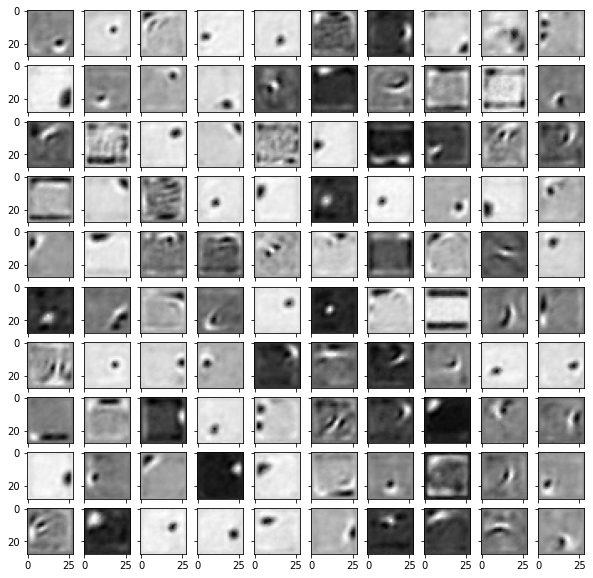

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "third layer standard params")


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.transpose(0,1).numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.transpose(0,1).numpy()
learned_weights_layer_4_for_product  = dbn_emnist.rbm_layers[3].W.transpose(0,1).numpy()

# learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , .1)
# learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , .1)
# learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , .1)
# learned_weights_layer_4_for_product  = _apply_threshold(learned_weights_layer_4_for_product , .1)

learned_weights_product = (learned_weights_layer_1_for_product.T @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product @ learned_weights_layer_4_for_product.T).T  # here we do the projection
# learned_weights_product = _apply_threshold(learned_weights_product, .1)
learned_weights_product.shape

(2000, 784)

In [ ]:
learned_weights_layer_3_for_product.shape

(500, 500)

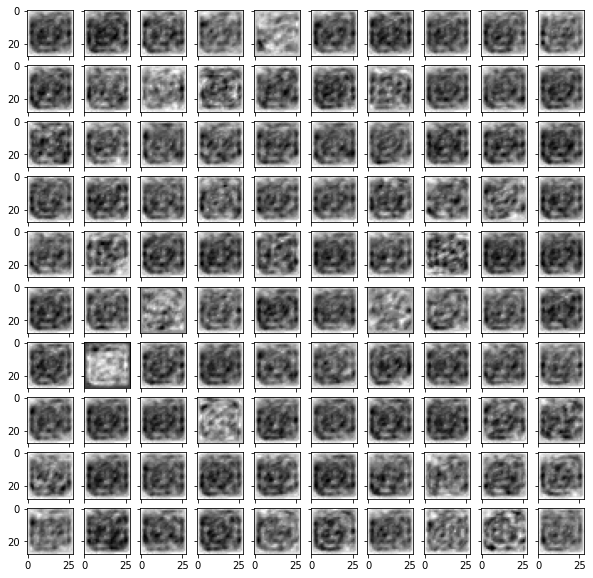

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "4th layer standard params")


##### Clustering internal representations

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)
label_to_mean_hidd_repr_4 = _get_label_to_mean_hidd_repr(hidden_repr_layer_4)


In [ ]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)
mean_hidd_repr_matrix_4 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_4)


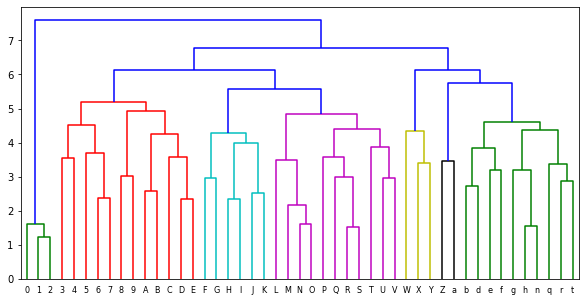

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "dendogram layer 1 standard DBN")

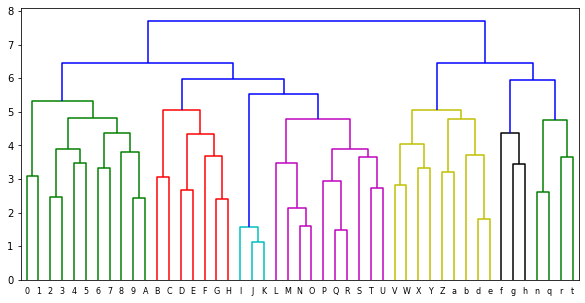

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "dendogram layer 2 standard DBN")

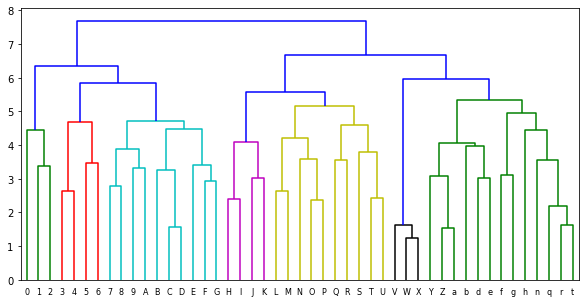

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "dendogram layer 3 standard DBN")


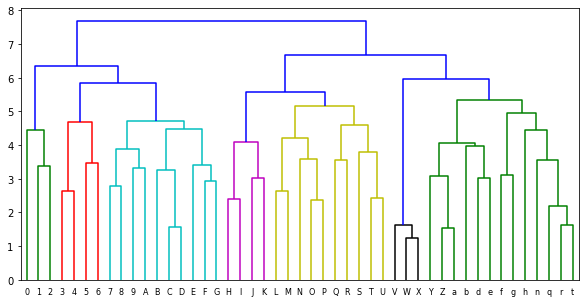

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "dendogram layer 3 standard DBN")


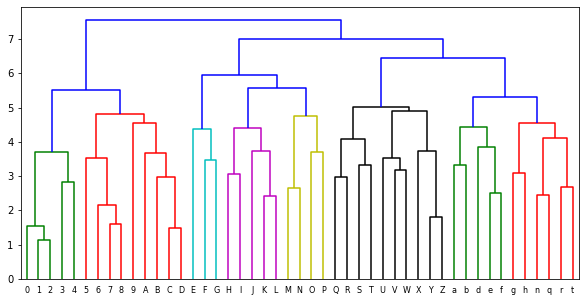

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_4, "dendogram layer 4 standard DBN")


##### Linear read out

In [ ]:
_move_parameters_to_cpu(dbn_emnist)


In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_4 , epochs=1000)

epoch 0/1000, loss = 3.867856
epoch 100/1000, loss = 1.113809
epoch 200/1000, loss = 0.795665
epoch 300/1000, loss = 0.663482
epoch 400/1000, loss = 0.586355
epoch 500/1000, loss = 0.534038
epoch 600/1000, loss = 0.495302
epoch 700/1000, loss = 0.464915
epoch 800/1000, loss = 0.440081
epoch 900/1000, loss = 0.419160


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)

predictions = perceptron_first_hidden(hidden_repr_layer_4_test)
print("Accuracy", _compute_accuracy(predictions, emnist_targets_test))


Accuracy 0.8442080616950989


In [ ]:
predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
predictions_indices

tensor([45, 44, 43,  ..., 41, 38, 42])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
predictions_indices

cm = confusion_matrix(emnist_targets_test, predictions_indices)
fig, ax = plt.subplots(figsize=(25, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig("cm for standard DBN")

plt.show()

##### Learning rate = 0.00001

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units= [500,  500,  500, 2000],
                k=1,
                learning_rate=0.000001,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=True,
                use_gpu=True) # set to true if u have gpu
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |12.5887   |0.2398   |0.2033 |0.0079   |
|20    |9.3016   |0.1283   |0.0902 |0.0013   |
|30    |8.4066   |0.1309   |0.0627 |0.0006   |
|40    |7.9374   |0.1320   |0.0507 |0.0005   |
|50    |7.6102   |0.1318   |0.0440 |0.0004   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |7.1788   |0.1146   |0.0767 |0.0045   |
|20    |6.3591   |0.0611   |0.0203 |0.0006   |
|30    |6.2051   |0.0570   |0.0123 |0.0003   |
|40    |6.1133   |0.0554   |0.0107 |0.0002   |
|50    |6.0400   |0.0525   |0.0102 |0.0002   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |5.7909   |0.1230   |0.0942 |0.0048   |
|20    |4.3171   |0.0341   |0.0283 |0.0007   |
|30    |4.0246   |0.0284   |0.0156 |0.0002   |
|40    |3.8930   |0.0282   |0.0114 |0.0001   |
|50    |3.8093   |0.0281   |0.0096 |0.000

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1.shape

(500, 784)

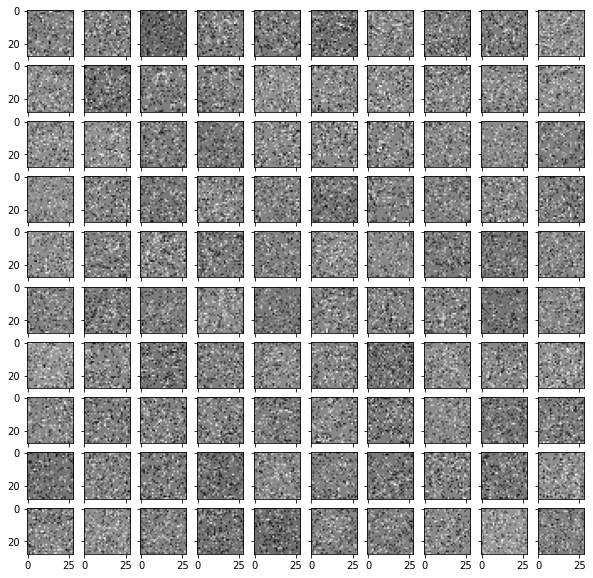

In [ ]:


_plot_layer_receptive_fields(learned_weights_layer_1, "lr layer 1")

In [ ]:
learned_weights_layer_1_for_product = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1_for_product = _apply_threshold(learned_weights_layer_1_for_product, 0)
learned_weights_layer_2_for_product = _apply_threshold(learned_weights_layer_2_for_product, 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

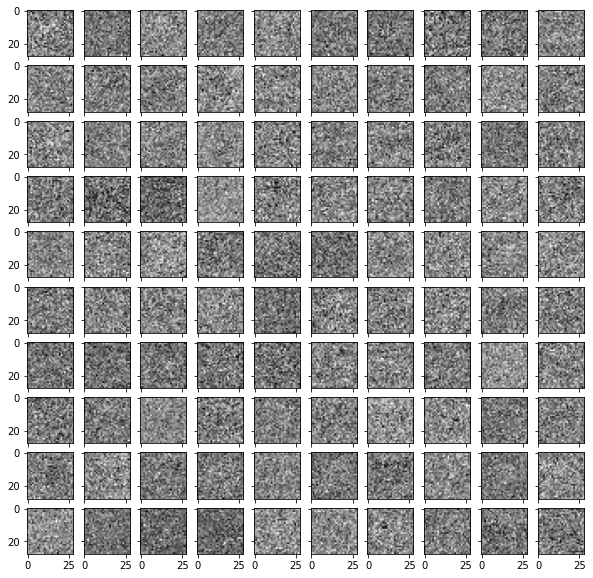

In [ ]:
_plot_layer_receptive_fields(learned_weights_product)


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

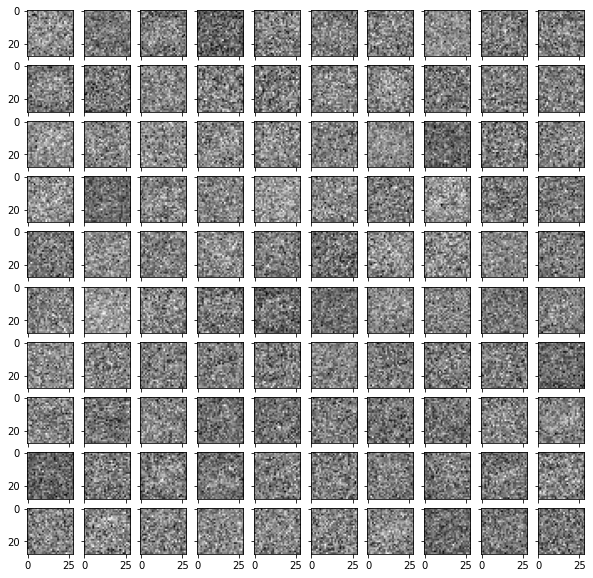

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "lr layer 3")


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()
learned_weights_layer_4_for_product  = dbn_emnist.rbm_layers[3].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)
learned_weights_layer_4_for_product  = _apply_threshold(learned_weights_layer_4_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product @ learned_weights_layer_4_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(2000, 784)

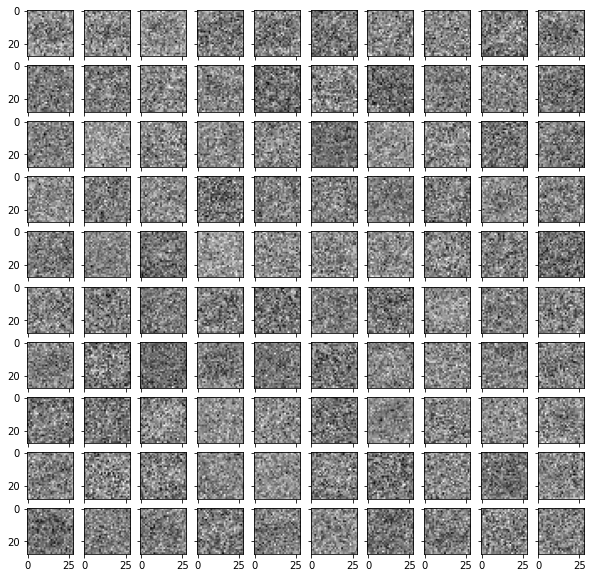

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "lr layer 4")


In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_4 , epochs=1000)

epoch 0/1000, loss = 3.882344
epoch 100/1000, loss = 3.513973
epoch 200/1000, loss = 3.120987
epoch 300/1000, loss = 2.783315
epoch 400/1000, loss = 2.511535
epoch 500/1000, loss = 2.298532
epoch 600/1000, loss = 2.132823
epoch 700/1000, loss = 2.003679
epoch 800/1000, loss = 1.901667
epoch 900/1000, loss = 1.819744


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)

predictions = perceptron_first_hidden(hidden_repr_layer_4_test)
print("Accuracy", _compute_accuracy(predictions, emnist_targets_test))


Accuracy 0.5575059056282043


##### Weight decay = 0.2 (invece che 0.00002)

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units= [500,  500,  500, 2000],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.2,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=True) # set to true if u have gpu
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |4.6859   |0.1628   |570.2573 |24.3406   |
|20    |4.6949   |0.1624   |564.9668 |24.3834   |
|30    |4.7030   |0.1661   |563.8550 |26.3569   |
|40    |4.6939   |0.1621   |562.2017 |25.8747   |
|50    |4.6918   |0.1613   |560.8973 |25.6401   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.7436   |0.1297   |318.8941 |42.0030   |
|20    |1.7306   |0.1296   |314.0391 |40.7924   |
|30    |1.7540   |0.1279   |320.0222 |42.5376   |
|40    |1.7290   |0.1190   |312.5744 |39.6198   |
|50    |1.7332   |0.1179   |313.3393 |38.5581   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1622   |0.1030   |219.9758 |42.0512   |
|20    |1.1688   |0.1110   |209.5414 |45.0738   |
|30    |1.1638   |0.1014   |204.3339 |39.9457   |
|40    |1.2149   |0.1317   |204.5185 |43.9790   |


In [ ]:
_move_parameters_to_cpu(dbn_emnist)

In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1.shape

(500, 784)

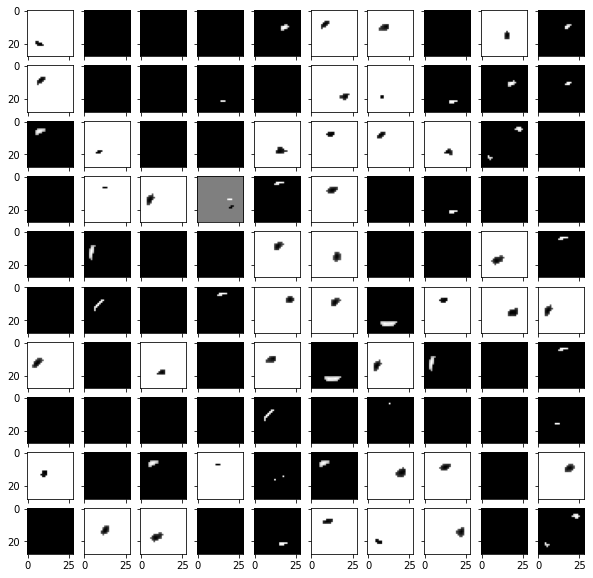

In [ ]:


_plot_layer_receptive_fields(learned_weights_layer_1, "weight decay layer 1")

In [ ]:
learned_weights_layer_1_for_product = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1_for_product = _apply_threshold(learned_weights_layer_1_for_product, 0)
learned_weights_layer_2_for_product = _apply_threshold(learned_weights_layer_2_for_product, 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

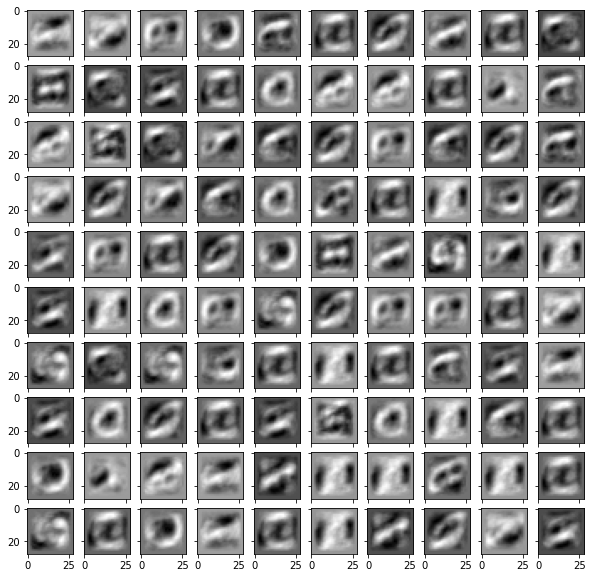

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "weight decay layer 2")


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

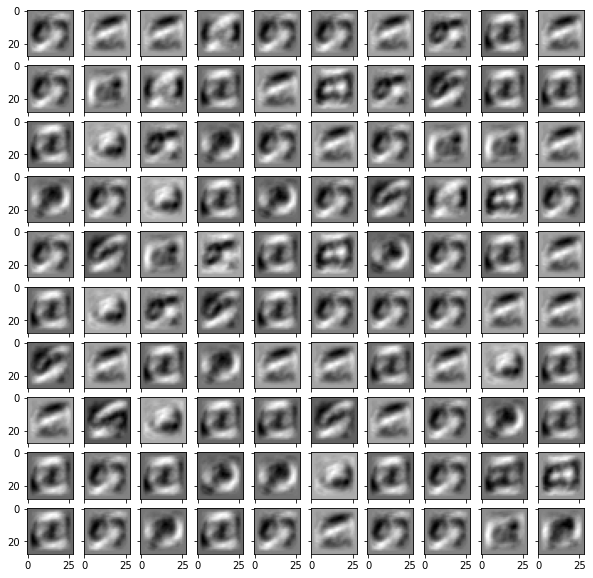

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "weights decay layer 3")


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()
learned_weights_layer_4_for_product  = dbn_emnist.rbm_layers[3].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)
learned_weights_layer_4_for_product  = _apply_threshold(learned_weights_layer_4_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product @ learned_weights_layer_4_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(2000, 784)

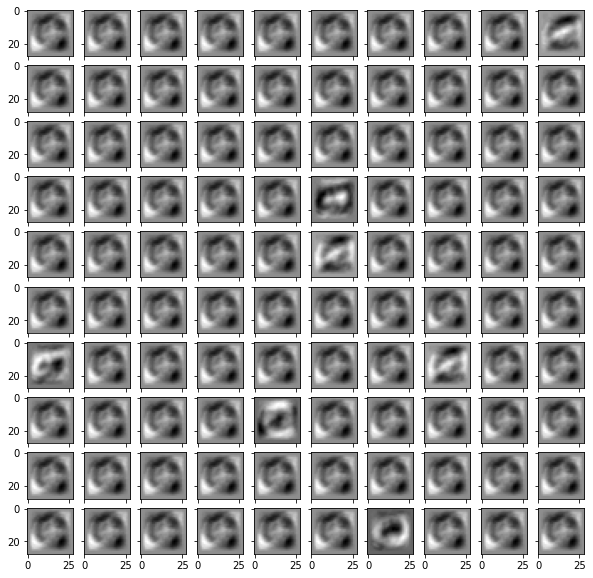

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "weight decay layer 4")


In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_4 , epochs=1000)

epoch 0/1000, loss = 3.858073
epoch 100/1000, loss = 3.040954
epoch 200/1000, loss = 2.896581
epoch 300/1000, loss = 2.835997
epoch 400/1000, loss = 2.802633
epoch 500/1000, loss = 2.781354
epoch 600/1000, loss = 2.766448
epoch 700/1000, loss = 2.755292
epoch 800/1000, loss = 2.746516
epoch 900/1000, loss = 2.739327


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)

predictions = perceptron_first_hidden(hidden_repr_layer_4_test)
print("Accuracy", _compute_accuracy(predictions, emnist_targets_test))


Accuracy 0.22836878895759583


##### Xavier init = TRUE

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units= [500,  500,  500, 2000],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=True,
                increase_to_cd_k=False,
                use_gpu=True) # set to true if u have gpu
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0445   |0.0352   |329.1522 |6.0062   |
|20    |0.9869   |0.0321   |307.9749 |5.3520   |
|30    |0.9668   |0.0315   |299.8255 |6.2257   |
|40    |0.9563   |0.0306   |294.4452 |5.1766   |
|50    |0.9494   |0.0311   |292.0187 |4.8733   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1037   |0.0315   |226.5232 |3.5673   |
|20    |1.0438   |0.0291   |217.6384 |3.0603   |
|30    |1.0300   |0.0290   |216.1171 |2.8440   |
|40    |1.0233   |0.0277   |215.0057 |3.0714   |
|50    |1.0198   |0.0300   |214.3581 |3.1733   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0197   |0.0319   |223.6762 |4.5488   |
|20    |0.9182   |0.0289   |201.6977 |3.3316   |
|30    |0.8811   |0.0270   |195.6229 |3.1699   |
|40    |0.8668   |0.0271   |192.8348 |2.9128   |
|50    |0.8624

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

##### Clustering internal representations

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)
label_to_mean_hidd_repr_4 = _get_label_to_mean_hidd_repr(hidden_repr_layer_4)


In [ ]:
mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)
mean_hidd_repr_matrix_4 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_4)


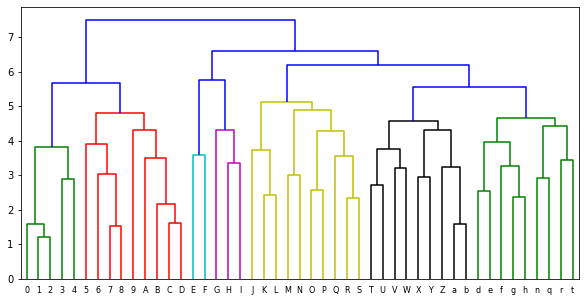

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "dendogram layer 1 xavier DBN")

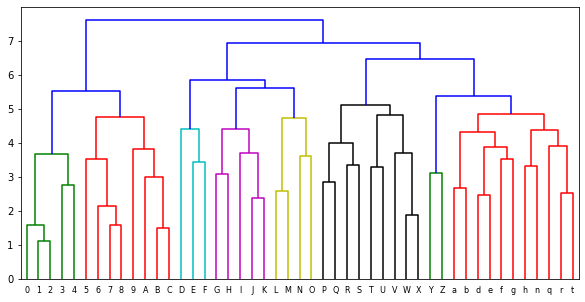

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "dendogram layer 2 xavier DBN")

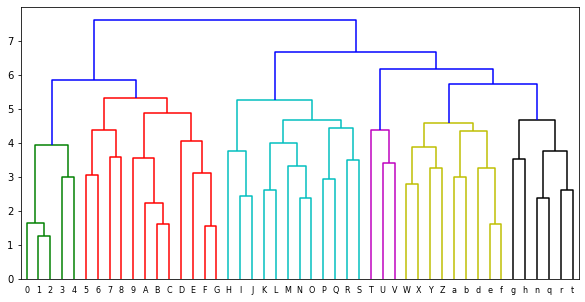

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "dendogram layer 3 xavier DBN")


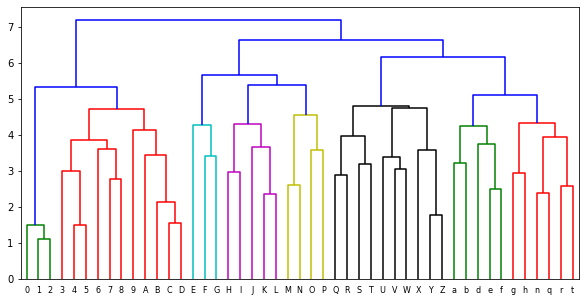

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_4, "dendogram layer 4 xavier DBN")


In [ ]:
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1.shape

(500, 784)

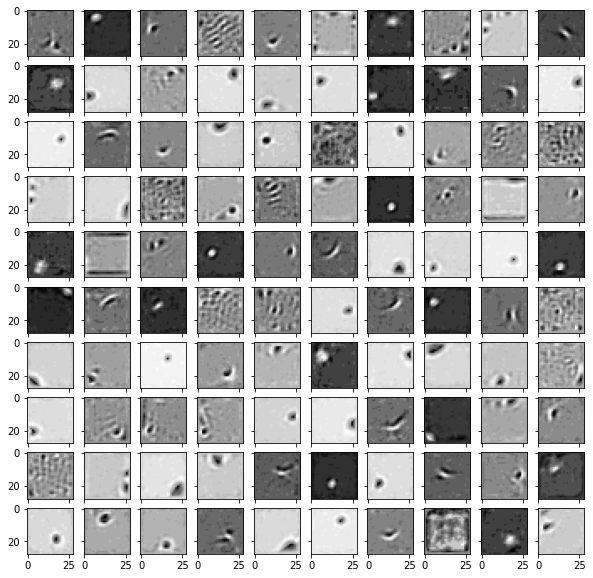

In [ ]:


_plot_layer_receptive_fields(learned_weights_layer_1)

In [ ]:
learned_weights_layer_1_for_product = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product = dbn_emnist.rbm_layers[1].W.numpy()

learned_weights_layer_1_for_product = _apply_threshold(learned_weights_layer_1_for_product, 0)
learned_weights_layer_2_for_product = _apply_threshold(learned_weights_layer_2_for_product, 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

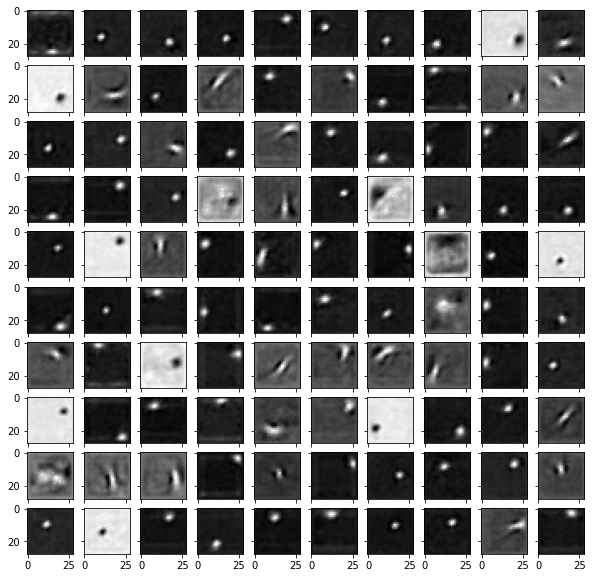

In [ ]:
_plot_layer_receptive_fields(learned_weights_product)


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(500, 784)

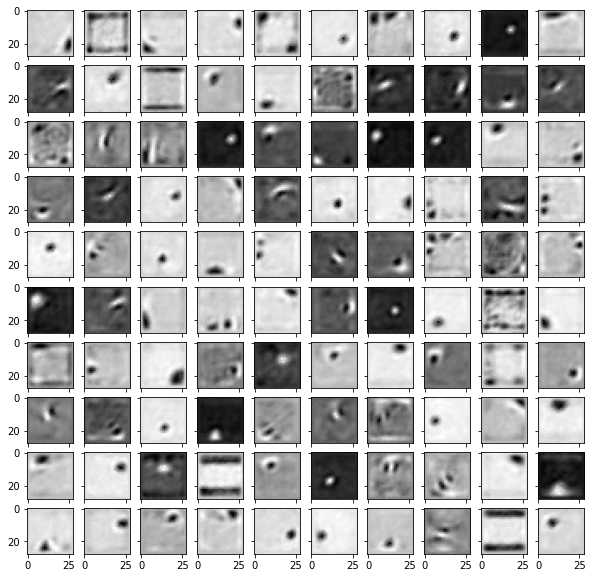

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "xavier layer 3")


In [ ]:
learned_weights_layer_1_for_product  = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2_for_product  = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3_for_product  = dbn_emnist.rbm_layers[2].W.numpy()
learned_weights_layer_4_for_product  = dbn_emnist.rbm_layers[3].W.numpy()

learned_weights_layer_1_for_product  = _apply_threshold(learned_weights_layer_1_for_product , 0)
learned_weights_layer_2_for_product  = _apply_threshold(learned_weights_layer_2_for_product , 0)
learned_weights_layer_3_for_product  = _apply_threshold(learned_weights_layer_3_for_product , 0)
learned_weights_layer_4_for_product  = _apply_threshold(learned_weights_layer_4_for_product , 0)

learned_weights_product = (learned_weights_layer_1_for_product @ learned_weights_layer_2_for_product @ learned_weights_layer_3_for_product @ learned_weights_layer_4_for_product).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)
learned_weights_product.shape

(2000, 784)

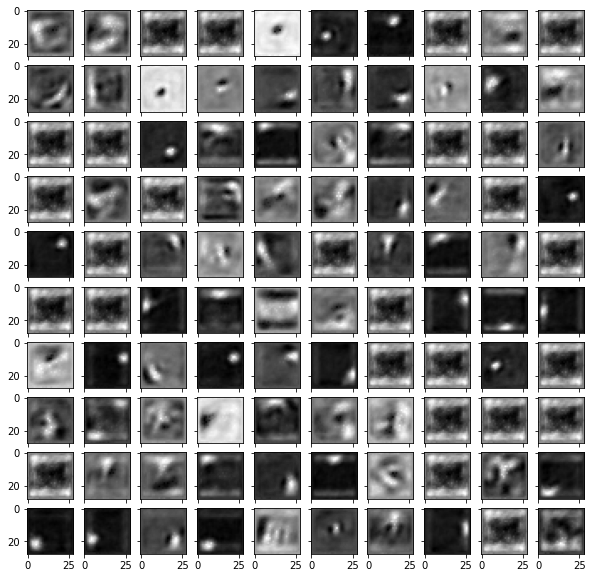

In [ ]:
_plot_layer_receptive_fields(learned_weights_product, "xavier layer 4")


In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)


In [ ]:
rbm_layer_size = dbn_emnist.rbm_layers[-1].W.shape[1]
perceptron_first_hidden = Perceptron(rbm_layer_size)
_train(perceptron_first_hidden, hidden_repr_layer_4 , epochs=1000)

epoch 0/1000, loss = 3.850965
epoch 100/1000, loss = 1.157417
epoch 200/1000, loss = 0.826830
epoch 300/1000, loss = 0.689692
epoch 400/1000, loss = 0.609806
epoch 500/1000, loss = 0.555840
epoch 600/1000, loss = 0.516121
epoch 700/1000, loss = 0.485179
epoch 800/1000, loss = 0.460072
epoch 900/1000, loss = 0.439064


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)

predictions = perceptron_first_hidden(hidden_repr_layer_4_test)
print("Accuracy", _compute_accuracy(predictions, emnist_targets_test))


Accuracy 0.840484619140625


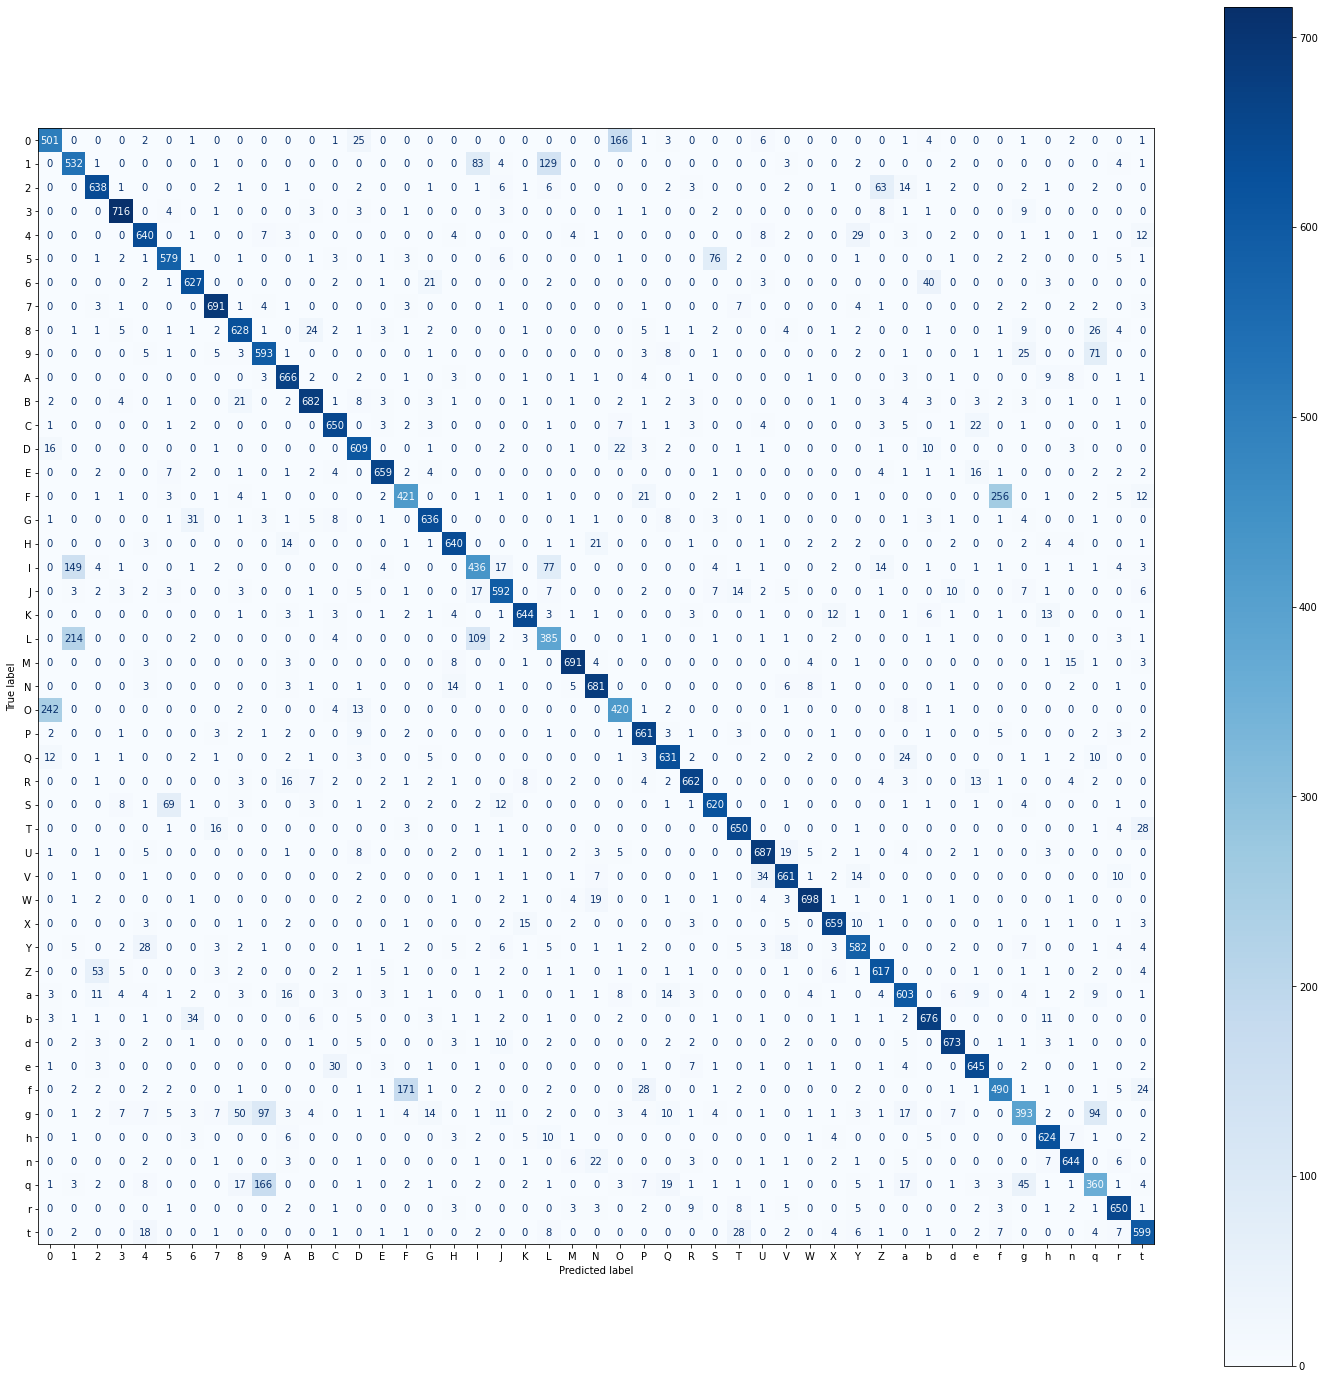

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
predictions_indices

cm = confusion_matrix(emnist_targets_test, predictions_indices)
fig, ax = plt.subplots(figsize=(25, 25))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.savefig("cm for standard DBN")

plt.show()

### CNN

In [ ]:
def prepare_data_for_cnn(data_to_transform):
    # data = data_to_transform.copy().values
    data = data_to_transform.reshape(-1, 28, 28)
    data = X_rgb = np.stack([data, data, data], axis=-1)
    return data

In [ ]:
# Reshape image for CNN
x_train = train_images.reshape(-1, 28, 28, 1)
x_test= test_images.reshape(-1, 28, 28, 1)
y_train = tensorflow.keras.utils.to_categorical(train_labels, 47)
y_test = tensorflow.keras.utils.to_categorical(test_labels, 47)


In [ ]:
x_test.shape

(18800, 28, 28, 1)

In [ ]:
y_test.shape

(18800, 47)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Sequential
model = Sequential()

model.add(Conv2D(filters=512, kernel_size=(5,5), padding = 'same', activation='relu',name="conv_1",\
                 input_shape=(28, 28,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), padding = 'same', activation='relu',name="conv_2"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',name="conv_3"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu', name="conv_5"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=len(label), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 512)       13312     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 512)      0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 256)       3277056   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 conv_3 (Conv2D)             (None, 7, 7, 128)         819328    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [ ]:
history = model.fit(x_train, y_train, epochs=5, batch_size=1024, verbose=1, \
                    validation_split=0.2)

Epoch 1/5
89/89 [==============================] - 31s 234ms/step - loss: 2.1298 - accuracy: 0.4218 - val_loss: 0.6151 - val_accuracy: 0.8044
Epoch 2/5
89/89 [==============================] - 20s 220ms/step - loss: 0.7539 - accuracy: 0.7689 - val_loss: 0.4533 - val_accuracy: 0.8431
Epoch 3/5
89/89 [==============================] - 20s 220ms/step - loss: 0.5640 - accuracy: 0.8195 - val_loss: 0.4018 - val_accuracy: 0.8604
Epoch 4/5
89/89 [==============================] - 20s 221ms/step - loss: 0.4755 - accuracy: 0.8441 - val_loss: 0.3654 - val_accuracy: 0.8690
Epoch 5/5
89/89 [==============================] - 20s 220ms/step - loss: 0.4159 - accuracy: 0.8595 - val_loss: 0.3765 - val_accuracy: 0.8635


In [ ]:
model.evaluate(x_test, y_test)

588/588 [==============================] - 3s 6ms/step - loss: 0.3909 - accuracy: 0.8676


[0.39087313413619995, 0.8676064014434814]

In [ ]:
def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [ ]:
for layer in model.layers:
  print(layer)


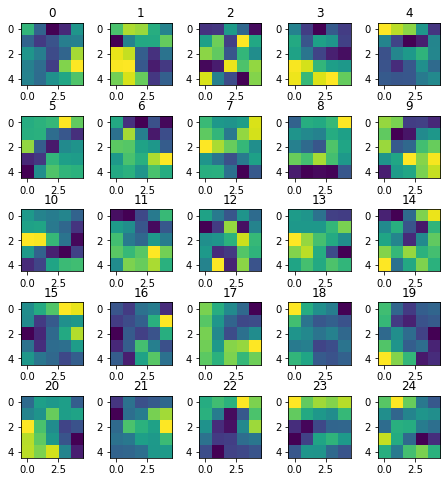

In [ ]:
plot_conv_weights(model, "conv_2")

g


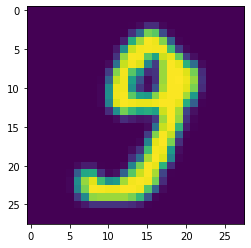

In [ ]:
print(label[test_labels[0]])
plt.imshow(test_images[0].reshape((28,28)))


In [ ]:
from keras.models import Model
outputs = model.layers[6].output
model_new = Model(inputs=model.inputs, outputs=outputs)

(1, 3, 3, 64)


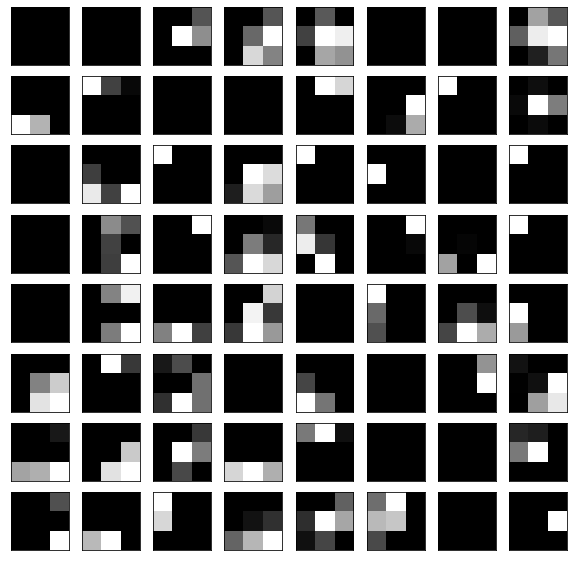

In [ ]:
feature_maps = model_new.predict(test_images[0].reshape(-1, 28, 28, 1))
print(feature_maps.shape)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(10,10))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :,:, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.savefig("CNN quarto conv2d")
plt.show()

In [ ]:
plt.imshow(feature_maps[0].reshape(28,28), cmap='gray')

ValueError: ignored

In [ ]:
x_train = prepare_data_for_resnet50(train_images)
x_test = prepare_data_for_resnet50(test_images)


In [ ]:
x_train.shape

(112800, 28, 28, 3)

In [ ]:
y_train = tensorflow.keras.utils.to_categorical(train_labels, 47)
y_test = tensorflow.keras.utils.to_categorical(test_labels, 47)


In [ ]:
model = ResNet50(include_top=False, pooling='avg', input_shape=(28,28,3))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg'))

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(124, activation='relu'))
# model.add(Dropout(0.50))
model.add(Dense(47, activation='softmax'))

# model.layers[0].trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
h = model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10
353/353 [==============================] - 47s 88ms/step - loss: 0.7492 - accuracy: 0.7910 - val_loss: 11496.5811 - val_accuracy: 0.0215
Epoch 2/10
353/353 [==============================] - 28s 79ms/step - loss: 0.4557 - accuracy: 0.8531 - val_loss: 6.5053 - val_accuracy: 0.0841
Epoch 3/10
353/353 [==============================] - 27s 78ms/step - loss: 0.3711 - accuracy: 0.8771 - val_loss: 8.2722 - val_accuracy: 0.8382
Epoch 4/10
353/353 [==============================] - 27s 76ms/step - loss: 0.5084 - accuracy: 0.8467 - val_loss: 0.8444 - val_accuracy: 0.7221
Epoch 5/10
353/353 [==============================] - 27s 76ms/step - loss: 0.4080 - accuracy: 0.8641 - val_loss: 0.8567 - val_accuracy: 0.8275
Epoch 6/10
353/353 [==============================] - 27s 76ms/step - loss: 0.3363 - accuracy: 0.8834 - val_loss: 0.4389 - val_accuracy: 0.8502
Epoch 7/10
353/353 [==============================] - 27s 77ms/step - loss: 0.3291 - accuracy: 0.8848 - val_loss: 0.3856 - val_accur

No handles with labels found to put in legend.


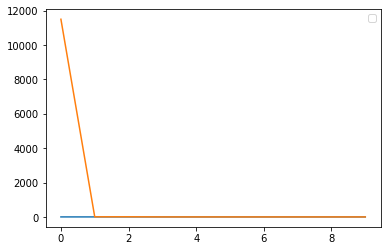

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend()

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.3552960753440857
Test accuracy: 0.8742552995681763


In [ ]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)


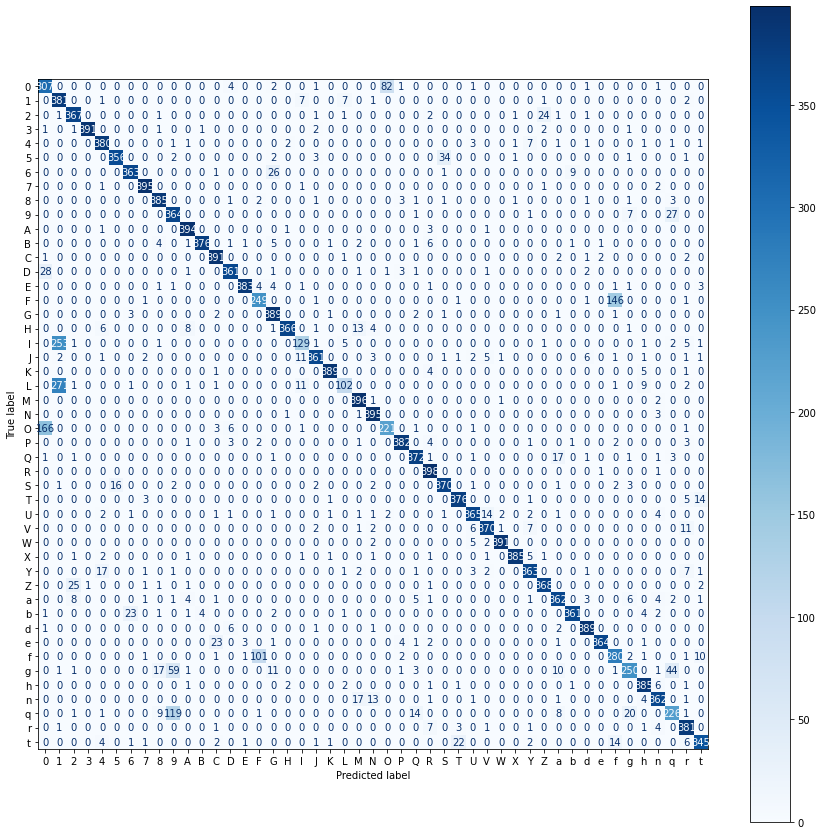

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
layer= model.layers[0].get_weights()
print(len(layer))
layer[0].shape

318


(7, 7, 3, 64)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 47)                96303     
                                                                 
Total params: 23,684,015
Trainable params: 23,630,895
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        print("ok")
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [ ]:
plot_conv_weights(model, "dense_1")